<h1 style='font-size:20px;text-align: center'>
A cloud effective radius (CER) and optical thickness (COT) retrieval framework using python; scikit-learn and TensorFlow: 
Application to the Moderate Resolution Imaging Spectroradiometer (MODIS) on board NASA's Terra & Aqua satellites.
</h1>

<p style='text-align: center'>Author: Benjamin Marchant
<br>marchant.benjamin01@gmail.com
<br> benjamin.marchant@nasa.gov
</p>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd
import matplotlib as mpl
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import warnings

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C
from sklearn import preprocessing
from pyhdf.SD import SD, SDC 
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from pylab import figure, cm
from scipy import misc
from joblib import dump, load
from scipy.optimize import minimize, rosen, rosen_der    
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
reflectance_ice_library = SD('./MODIS_C6_LUTS/modis_ice/reflectance_ice_library.hdf', SDC.READ)

print( reflectance_ice_library.info() )

(17, 8)


In [5]:
datasets_dic = reflectance_ice_library.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    #print( idx,sds )
    sds_obj = reflectance_ice_library.select(sds)
    print( sds_obj.info() )

('MultiScatBDReflectance', 6, [28, 33, 37, 34, 7, 12], 5, 2)
('StdDevMultiScatBDReflectance', 6, [28, 33, 37, 34, 7, 12], 5, 2)
('Wavelengths', 1, 7, 5, 3)
('OpticalThickness', 1, 34, 5, 4)
('ParticleRadius', 1, 12, 5, 3)
('ReflectanceSolarZenith', 1, 33, 5, 5)
('ReflectanceSensorZenith', 1, 28, 5, 5)
('ReflectanceRelativeAzimuth', 1, 37, 5, 4)
('ExtinctionCoefficient', 2, [12, 7], 5, 3)
('SingleScatterAlbedo', 2, [12, 7], 5, 3)
('Phase: AsymmetryParameter', 2, [12, 7], 5, 3)
('TruncationFactor', 2, [12, 7], 5, 3)
('PhaseFuncNormConstant', 2, [12, 7], 5, 3)
('FluxSolarZenith', 1, 33, 5, 4)
('ReflectedFlux', 4, [33, 34, 7, 12], 5, 2)
('TransmittedFlux', 4, [33, 34, 7, 12], 5, 2)
('SphericalAlbedo', 3, [12, 7, 34], 5, 2)


(28, 33, 37, 34, 7, 12)


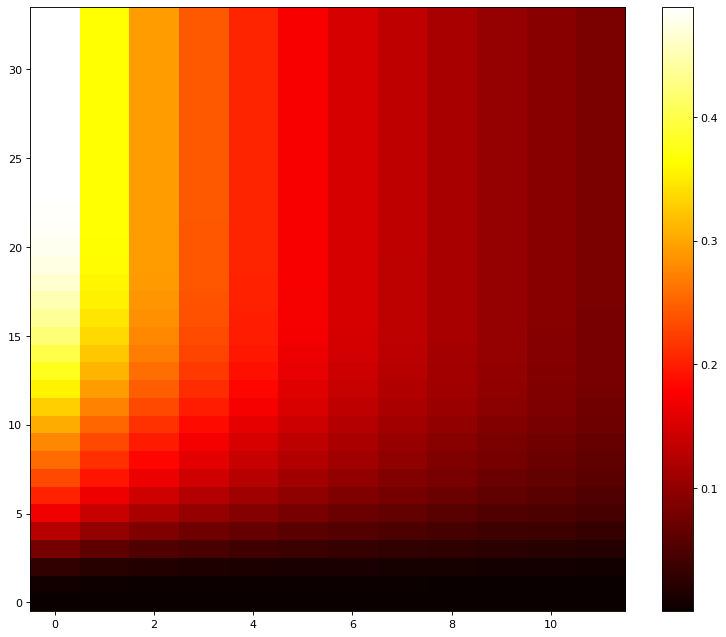

In [6]:
MultiScatBDReflectance = reflectance_ice_library.select('MultiScatBDReflectance')

MultiScatBDReflectance = MultiScatBDReflectance.get()

print(MultiScatBDReflectance.shape)

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
plt.imshow(MultiScatBDReflectance[8,3,13,:,4,:], cmap='hot', interpolation='nearest',origin='lower')

plt.colorbar()

ax.set_aspect('auto')

plt.show()

In [7]:
OpticalThickness = reflectance_ice_library.select('OpticalThickness')
OpticalThickness = OpticalThickness.get()

print(OpticalThickness.shape)

print(OpticalThickness)

(34,)
[5.0000e-02 1.0000e-01 2.5000e-01 5.0000e-01 7.5000e-01 1.0000e+00
 1.2500e+00 1.5000e+00 1.7500e+00 2.0000e+00 2.3900e+00 2.8700e+00
 3.4500e+00 4.1400e+00 4.9700e+00 5.9600e+00 7.1500e+00 8.5800e+00
 1.0300e+01 1.2360e+01 1.4830e+01 1.7800e+01 2.1360e+01 2.5630e+01
 3.0760e+01 3.6910e+01 4.4300e+01 5.3160e+01 6.3800e+01 7.6560e+01
 9.1880e+01 1.1026e+02 1.3231e+02 1.5878e+02]


In [8]:
ParticleRadius = reflectance_ice_library.select('ParticleRadius')
ParticleRadius = ParticleRadius.get()

print(ParticleRadius.shape)

print(ParticleRadius)

(12,)
[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60.]


In [9]:
y = MultiScatBDReflectance[8,3,13,:,4,:]

print(y.shape)

(34, 12)


In [10]:
print( y.max() )
print( y.min() )

0.4885463
0.0005173092


In [11]:
x1, x2 = np.meshgrid(np.arange(0,12, 1), np.arange(0,34, 1))

print(34*12)

x1 = x1.flatten()
x2 = x2.flatten()

x1 = ParticleRadius[x1]
x2 = OpticalThickness[x2]

y = y.flatten()

408


In [12]:
X = np.stack((x1,x2),axis=-1)

In [13]:
X = pd.DataFrame(X,columns=['tau','cer'])

In [14]:
X_stats = X.describe()
X_stats = X_stats.transpose()
X_stats

,count,mean,std,min,25%,50%,75%,max
tau,408.0,32.500000,17.281454,5.00,18.75,32.500,46.25,60.000000
cer,408.0,27.931179,40.622723,0.05,1.75,7.865,36.91,158.779999


In [15]:
def data_scaling_function(x):
  return (x - X_stats['mean']) / X_stats['std']

In [16]:
X = data_scaling_function(X)

test_stats = X.describe()
test_stats = test_stats.transpose()
test_stats

,count,mean,std,min,25%,50%,75%,max
tau,408.0,3.506156e-09,1.0,-1.591301,-0.795651,0.000000,0.795651,1.591301
cer,408.0,-3.739899e-08,1.0,-0.686344,-0.644496,-0.493964,0.221030,3.221075


In [17]:
y = pd.DataFrame(y,columns=['MultiScatBDReflectance'])

In [18]:
t = pd.concat((X,y),axis=1)

In [19]:
t = t.sample(frac = 1) 

t

,tau,cer,MultiScatBDReflectance
247,0.433991,-0.322509,0.132066
343,0.433991,0.882974,0.132076
28,-0.433991,-0.681421,0.014942
328,-0.433991,0.621052,0.205039
206,-1.012646,-0.476363,0.288112
...,...,...,...
221,-0.144664,-0.434023,0.174297
176,0.723319,-0.565230,0.114321
120,-1.591301,-0.628741,0.303912
52,-0.433991,-0.669113,0.067744


In [20]:
X_train = t[['tau','cer']]
y_train = t[['MultiScatBDReflectance']]

In [21]:
def build_regression_model(intput_x):
    model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=[intput_x.shape[1]]),
    layers.Dense(10, activation='tanh'),
    layers.Dense(1)
    ])
    
    opt = tf.keras.optimizers.RMSprop(0.01)
    
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

    return model

reg_model = build_regression_model(X_train)

In [22]:
reg_model.fit(X_train, y_train, epochs=3000,
          validation_split = 0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.5227,  mse:0.5227,  val_loss:0.3781,  val_mse:0.3781,  
....................................................................................................
Epoch: 100, loss:0.0035,  mse:0.0035,  val_loss:0.0038,  val_mse:0.0038,  
....................................................................................................
Epoch: 200, loss:0.0030,  mse:0.0030,  val_loss:0.0033,  val_mse:0.0033,  
....................................................................................................
Epoch: 300, loss:0.0025,  mse:0.0025,  val_loss:0.0028,  val_mse:0.0028,  
....................................................................................................
Epoch: 400, loss:0.0021,  mse:0.0021,  val_loss:0.0024,  val_mse:0.0024,  
....................................................................................................
Epoch: 500, loss:0.0018,  mse:0.0018,  val_loss:0.0020,  val_mse:0.0020,  
..............................................

In [23]:
X_test = np.stack((x1,x2),axis=-1)

X_test = pd.DataFrame(X_test,columns=['tau','cer'])

X_test = data_scaling_function(X_test)

In [24]:
yhat = reg_model.predict(X_test)

In [25]:
print(yhat.min())
print(yhat.max())

-0.00394205
0.48372492


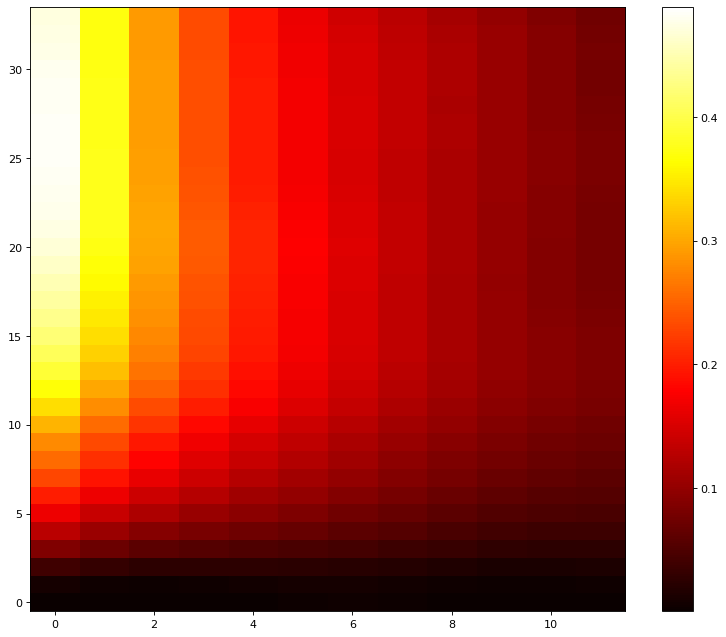

In [26]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
#plt.imshow(yhat.reshape(34,12), cmap='hot', interpolation='nearest',origin='lower',vmin=0.0005173092,vmax=0.4885463)
plt.imshow(yhat.reshape(34,12), cmap='hot', interpolation='nearest',origin='lower',vmin=0.0005173092,vmax=0.4885463)

plt.colorbar()

ax.set_aspect('auto')

plt.show()

In [27]:
y_test = y.to_numpy()

y_test = y_test.reshape(-1,1)

diff = np.sqrt( (yhat - y_test) * (yhat - y_test) )

for i in range(20):
        print(yhat[i,0],y_test[i,0],diff[i,0])

-0.00030011684 0.0018547118 0.0021548285
-0.00394205 0.0014079105 0.0053499606
-0.003789939 0.0011944784 0.0049844175
-0.0011825934 0.0010557779 0.0022383714
0.0020140633 0.0009482497 0.0010658136
0.0041430816 0.0008569037 0.003286178
0.004415892 0.00078008516 0.003635807
0.0030865893 0.00071383896 0.0023727503
0.0011227354 0.00065667776 0.00046605768
-0.00029800087 0.0006048536 0.0009028545
-0.00017074496 0.00055917684 0.0007299218
0.0021650419 0.0005173092 0.0016477327
0.010035209 0.0064317104 0.003603499
0.005114816 0.00486103 0.00025378633
0.0041136965 0.004106517 7.1795657e-06
0.0057295784 0.0036185712 0.0021110072
0.008098327 0.0032415132 0.0048568137
0.009544872 0.0029220253 0.0066228462
0.0092545375 0.002654156 0.006600382
0.007454954 0.0024239393 0.005031015


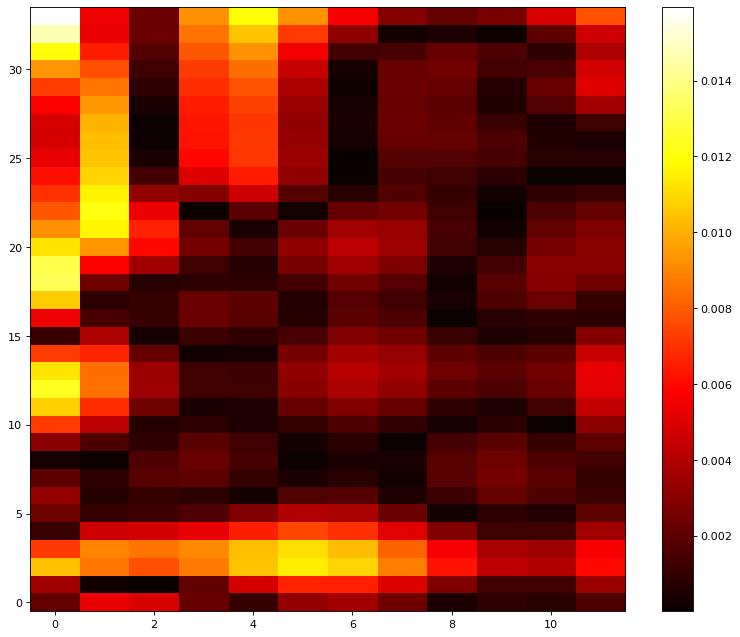

In [28]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
plt.imshow(diff.reshape(34,12), cmap='hot', interpolation='nearest',origin='lower')


plt.colorbar()

ax.set_aspect('auto')

plt.show()

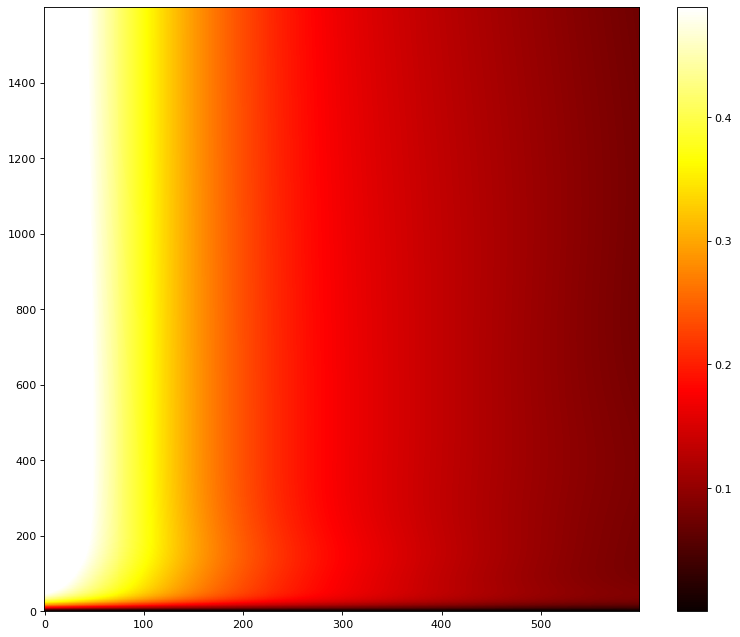

In [29]:
x1, x2 = np.meshgrid(np.arange(0,60, 0.1), np.arange(0,160, 0.1))

x1 = x1.flatten()
x2 = x2.flatten()

X_test = np.stack((x1,x2),axis=-1)

X_test = pd.DataFrame(X_test,columns=['tau','cer'])

X_test = data_scaling_function(X_test)

yhat = reg_model.predict(X_test)

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
plt.imshow(yhat.reshape(1600,600), cmap='hot', interpolation='nearest',origin='lower',vmin=0.0005173092,vmax=0.4885463)

plt.colorbar()

ax.set_aspect('auto')

plt.show()

In [76]:
y1 = MultiScatBDReflectance[8,3,13,:,0,:]
y2 = MultiScatBDReflectance[8,3,13,:,4,:]

y1 = y1.flatten()
y2 = y2.flatten()

Y = np.stack((y1,y2),axis=-1)

Y = pd.DataFrame(Y,columns=['band 1', 'band 6'])

Y

,band 1,band 6
0,0.001512,0.001855
1,0.001398,0.001408
2,0.001358,0.001194
3,0.001338,0.001056
4,0.001325,0.000948
...,...,...
403,0.813332,0.132076
404,0.812899,0.116770
405,0.812541,0.103426
406,0.812236,0.092441


In [77]:
t = pd.concat((X,Y),axis=1)

t = t.sample(frac = 1) 

t

,tau,cer,band 1,band 6
279,-0.723319,-0.056648,0.711355,0.242662
283,0.433991,-0.056648,0.707873,0.132076
0,-1.591301,-0.686344,0.001512,0.001855
393,1.012646,2.569469,0.807779,0.103426
65,-0.144664,-0.662959,0.146424,0.081061
...,...,...,...,...
202,1.301974,-0.511565,0.519227,0.092140
379,0.433991,2.026669,0.802934,0.132076
166,1.301974,-0.585662,0.416079,0.089839
360,-1.591301,1.574213,0.813420,0.488546


In [78]:
X_train = t[['tau','cer']]
y_train = t[['band 1', 'band 6']]

In [79]:
def build_multiple_regression_model(intput_x):
    model = keras.Sequential([
    layers.Dense(60, activation='tanh', input_shape=[intput_x.shape[1]]),
    layers.Dense(60, activation='tanh'),
    layers.Dense(60, activation='tanh'),
    layers.Dense(2)
    ])
    
    opt = tf.keras.optimizers.RMSprop(0.01)
    
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

    return model

mult_reg_model = build_multiple_regression_model(X_train)

In [80]:
mult_reg_model.fit(X_train, y_train, epochs=20000,
          validation_split = 0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1775,  mse:0.1775,  val_loss:0.0605,  val_mse:0.0605,  
....................................................................................................
Epoch: 100, loss:0.0015,  mse:0.0015,  val_loss:0.0018,  val_mse:0.0018,  
....................................................................................................
Epoch: 200, loss:0.0004,  mse:0.0004,  val_loss:0.0005,  val_mse:0.0005,  
....................................................................................................
Epoch: 300, loss:0.0004,  mse:0.0004,  val_loss:0.0006,  val_mse:0.0006,  
....................................................................................................
Epoch: 400, loss:0.0002,  mse:0.0002,  val_loss:0.0003,  val_mse:0.0003,  
....................................................................................................
Epoch: 500, loss:0.0001,  mse:0.0001,  val_loss:0.0002,  val_mse:0.0002,  
..............................................

....................................................................................................
Epoch: 4600, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 4700, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 4800, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 4900, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 5000, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 5100, l

....................................................................................................
Epoch: 13800, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 13900, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 14000, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 14100, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 14200, loss:0.0000,  mse:0.0000,  val_loss:0.0000,  val_mse:0.0000,  
....................................................................................................
Epoch: 14

In [81]:
x1, x2 = np.meshgrid(np.arange(0,60, 1), np.arange(0,160, 1))

x1 = x1.flatten()
x2 = x2.flatten()

X_test = np.stack((x1,x2),axis=-1)

X_test = pd.DataFrame(X_test,columns=['tau','cer'])

X_test = data_scaling_function(X_test)

yhat = mult_reg_model.predict(X_test)

yhat


array([[-0.00957335, -0.03196716],
       [-0.0069431 , -0.02392882],
       [-0.00455665, -0.01667086],
       ...,
       [ 0.81029207,  0.08742408],
       [ 0.8102108 ,  0.0856487 ],
       [ 0.81013066,  0.08392937]], dtype=float32)

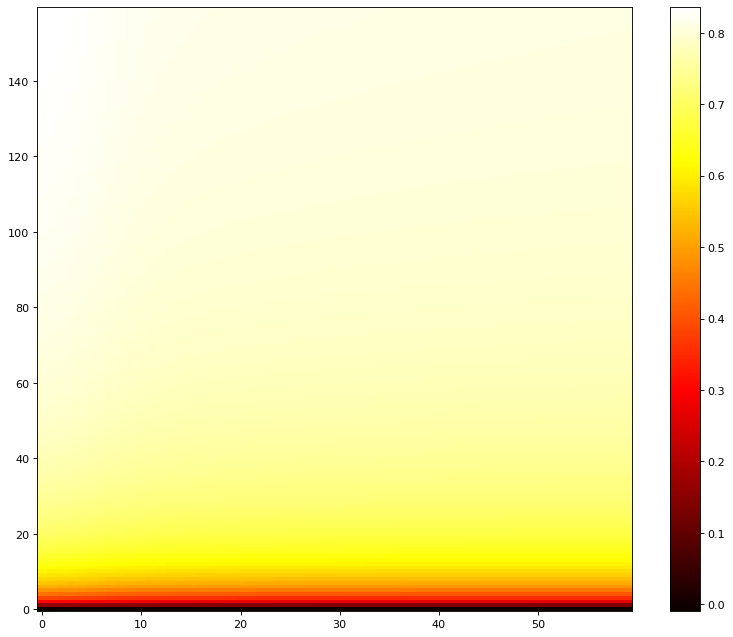

In [82]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
plt.imshow(yhat[:,0].reshape(160,60), cmap='hot', interpolation='nearest',origin='lower')

plt.colorbar()

ax.set_aspect('auto')

plt.show()

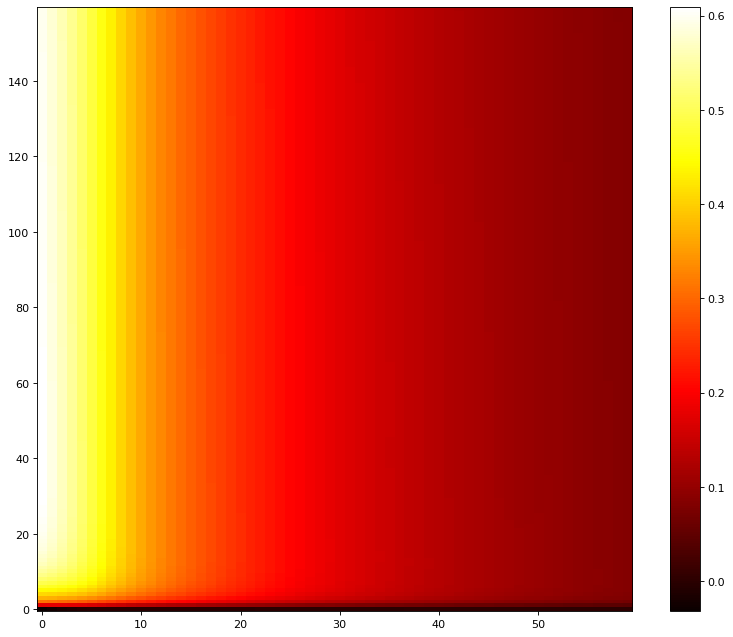

In [83]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111)
    
plt.imshow(yhat[:,1].reshape(160,60), cmap='hot', interpolation='nearest',origin='lower')

plt.colorbar()

ax.set_aspect('auto')

plt.show()

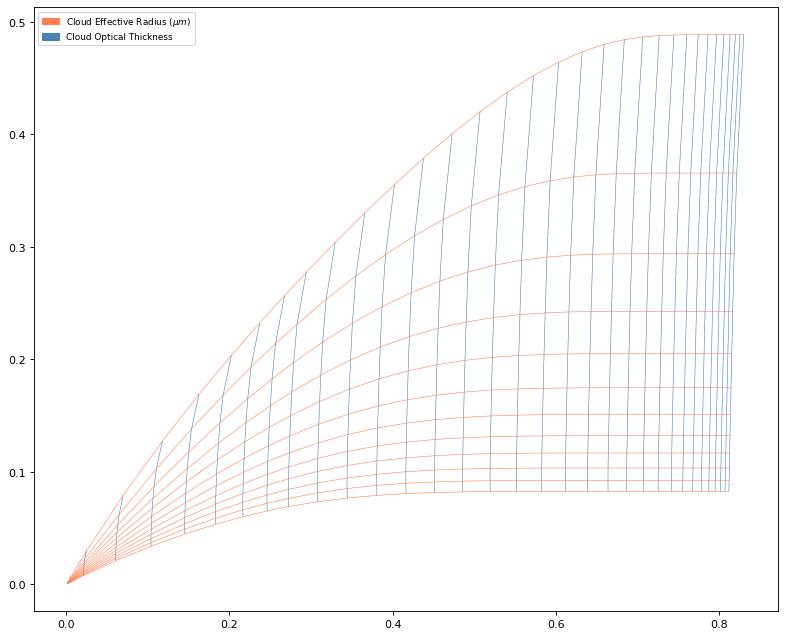

In [84]:
file = SD('./MODIS_C6_LUTS/modis_ice/reflectance_ice_library.hdf', SDC.READ)

x_band_idx = 0
y_band_idx = 4


ice_lut_shape = MultiScatBDReflectance.shape

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

x = [MultiScatBDReflectance[8,3,13,:,x_band_idx,index_re] for index_re in np.arange(ice_lut_shape[5])]
y = [MultiScatBDReflectance[8,3,13,:,y_band_idx,index_re] for index_re in np.arange(ice_lut_shape[5])]

plt.plot(x,y, 'steelblue',linewidth=0.5)

x = [MultiScatBDReflectance[8,3,13,index_tau,x_band_idx,:] for index_tau in np.arange(ice_lut_shape[3])]
y = [MultiScatBDReflectance[8,3,13,index_tau,y_band_idx,:] for index_tau in np.arange(ice_lut_shape[3])]

plt.plot(x,y, 'coral',linewidth=0.5)

pop_a = mpatches.Patch(color='coral', label=r'Cloud Effective Radius ($\mu m$)')
pop_b = mpatches.Patch(color='steelblue', label='Cloud Optical Thickness')

plt.legend(handles=[pop_a,pop_b],fontsize=8)


plt.show()
plt.close()



In [85]:
x1, x2 = np.meshgrid(np.arange(0,12, 1), np.arange(0,34, 1))

print(34*12)

x1 = x1.flatten()
x2 = x2.flatten()

x1 = ParticleRadius[x1]
x2 = OpticalThickness[x2]

X_test = np.stack((x1,x2),axis=-1)

X_test = pd.DataFrame(X_test,columns=['tau','cer'])

X_test = data_scaling_function(X_test)

yhat = mult_reg_model.predict(X_test)

yhat.shape

yhat = yhat.reshape(34,12,2)

408


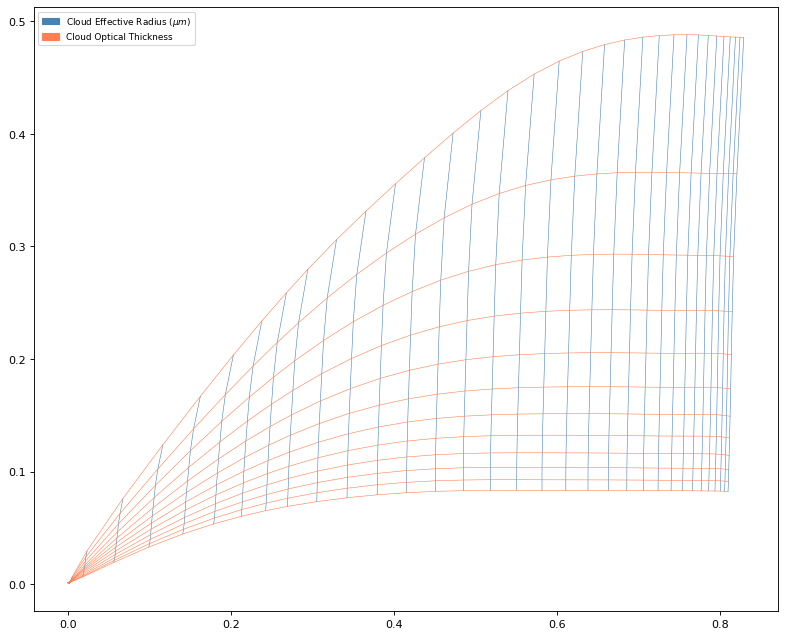

In [86]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')



x = [yhat[:,index_re,0] for index_re in np.arange(ice_lut_shape[5])]
y = [yhat[:,index_re,1] for index_re in np.arange(ice_lut_shape[5])]

plt.plot(x,y, 'steelblue',linewidth=0.5)


x = [yhat[index_tau,:,0] for index_tau in np.arange(ice_lut_shape[3])]
y = [yhat[index_tau,:,1] for index_tau in np.arange(ice_lut_shape[3])]

plt.plot(x,y, 'coral',linewidth=0.5)

pop_a = mpatches.Patch(color='steelblue', label=r'Cloud Effective Radius ($\mu m$)')
pop_b = mpatches.Patch(color='coral', label='Cloud Optical Thickness')

plt.legend(handles=[pop_a,pop_b],fontsize=8)


plt.show()
plt.close()



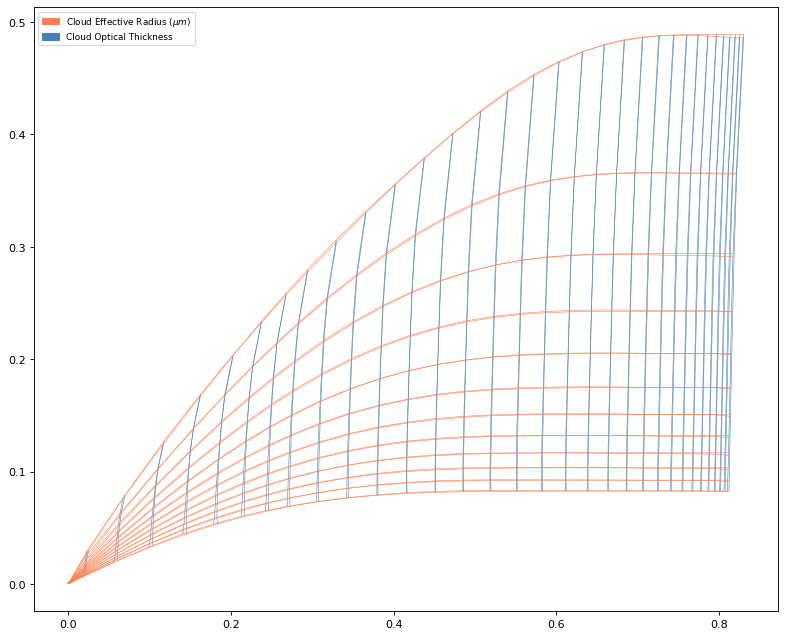

In [87]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

x = [MultiScatBDReflectance[8,3,13,:,x_band_idx,index_re] for index_re in np.arange(ice_lut_shape[5])]
y = [MultiScatBDReflectance[8,3,13,:,y_band_idx,index_re] for index_re in np.arange(ice_lut_shape[5])]

plt.plot(x,y, 'steelblue',linewidth=0.5)


x = [yhat[:,index_re,0] for index_re in np.arange(ice_lut_shape[5])]
y = [yhat[:,index_re,1] for index_re in np.arange(ice_lut_shape[5])]

plt.plot(x,y, 'steelblue',linewidth=0.5)

x = [MultiScatBDReflectance[8,3,13,index_tau,x_band_idx,:] for index_tau in np.arange(ice_lut_shape[3])]
y = [MultiScatBDReflectance[8,3,13,index_tau,y_band_idx,:] for index_tau in np.arange(ice_lut_shape[3])]

plt.plot(x,y, 'coral',linewidth=0.5)

x = [yhat[index_tau,:,0] for index_tau in np.arange(ice_lut_shape[3])]
y = [yhat[index_tau,:,1] for index_tau in np.arange(ice_lut_shape[3])]

plt.plot(x,y, 'coral',linewidth=0.5)

pop_a = mpatches.Patch(color='coral', label=r'Cloud Effective Radius ($\mu m$)')
pop_b = mpatches.Patch(color='steelblue', label='Cloud Optical Thickness')

plt.legend(handles=[pop_a,pop_b],fontsize=8)

plt.show()
plt.close()

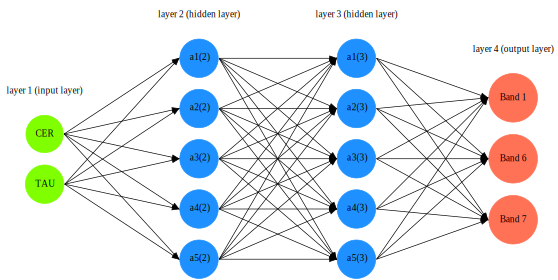

In [1]:
from graphviz import Digraph
from graphviz import Source

temp = '''
digraph G {


     graph[ fontname = "Helvetica-Oblique",
            fontsize = 12,
            label = "",
            size = "7.75,10.25" ];

    rankdir = LR;
    splines=false;
    edge[style=invis];
    ranksep= 1.4;
    {
    node [shape=circle, color=chartreuse, style=filled, fillcolor=chartreuse];
    x1 [label=<CER>];
    x2 [label=<TAU>]; 
}
{
    node [shape=circle, color=dodgerblue, style=filled, fillcolor=dodgerblue];
    a12 [label=<a<sub>1</sub><sup>(2)</sup>>];
    a22 [label=<a<sub>2</sub><sup>(2)</sup>>];
    a32 [label=<a<sub>3</sub><sup>(2)</sup>>];
    a42 [label=<a<sub>4</sub><sup>(2)</sup>>];
    a52 [label=<a<sub>5</sub><sup>(2)</sup>>];
    a13 [label=<a<sub>1</sub><sup>(3)</sup>>];
    a23 [label=<a<sub>2</sub><sup>(3)</sup>>];
    a33 [label=<a<sub>3</sub><sup>(3)</sup>>];
    a43 [label=<a<sub>4</sub><sup>(3)</sup>>];
    a53 [label=<a<sub>5</sub><sup>(3)</sup>>];
}
{
    node [shape=circle, color=coral1, style=filled, fillcolor=coral1];
    O1 [label=<Band 1>];
    O2 [label=<Band 6>]; 
    O3 [label=<Band 7>]; 
}
    {
        rank=same;
        x1->x2;
    }
    {
        rank=same;
        a12->a22->a32->a42->a52;
    }
    {
        rank=same;
        a13->a23->a33->a43->a53;
    }
    {
        rank=same;
        O1->O2->O3;
    }
    l0 [shape=plaintext, label="layer 1 (input layer)"];
    l0->x1;
    {rank=same; l0;x1};
    l1 [shape=plaintext, label="layer 2 (hidden layer)"];
    l1->a12;
    {rank=same; l1;a12};
    l2 [shape=plaintext, label="layer 3 (hidden layer)"];
    l2->a13;
    {rank=same; l2;a13};
    l3 [shape=plaintext, label="layer 4 (output layer)"];
    l3->O1;
    {rank=same; l3;O1};
    edge[style=solid, tailport=e, headport=w];
    {x1; x2} -> {a12;a22;a32;a42;a52};
    {a12;a22;a32;a42;a52} -> {a13;a23;a33;a43;a53};
    {a13;a23;a33;a43;a53} -> {O1,O2,O3};
}'''



s = Source(temp)

s